## Bibiliothèque

In [18]:
import numpy as np
import tensorflow as tf;
import matplotlib.pyplot as plt
from resnet import resnet_v2
from keras_flops import get_flops
import time
%matplotlib inline
seed = tf.random.set_seed(42)


In [19]:
def plot_hist(figname):
    plt.figure(figsize=(15,7))
    plt.subplot(121)
    plt.plot(accuracy, label = "train accuracy")
    plt.plot(val_accuracy, label = "validation accuracy")
    plt.title("Accuracy")
    plt.grid()
    plt.legend()

    plt.subplot(122)
    plt.plot(l, label = "train loss")
    plt.plot(val_l, label = "validation loss")
    plt.title("Loss")
    plt.grid()
    plt.legend()

    plt.savefig(figname)
    plt.show()
    
def inference_time():
    scratch = []
    pruned = []
    for i in range(10):
        t1 = time.time()
        pred1 = scratch_model(x_test)
        t2 = time.time()
        scratch.append(t2-t1)

        # Pruned model
        t3 = time.time()
        pred2 = P.model(x_test)
        t4 = time.time()
        pruned.append(t4-t3)

    # display
    print("Scratch inference time : ", np.mean(scratch), " s")
    print("Pruned inference time : ", np.mean(pruned), " s")
    return np.mean(pruned)


def count_parameters(model):
    somme = 0
    for l in model.trainable_variables:
        somme += np.count_nonzero(l)
    return somme



def scratch_hist():   
    loss = dico["scratch_hist"][0].history["loss"]
    val_loss = dico["scratch_hist"][0].history["val_loss"]
    accuracy = dico["scratch_hist"][0].history["sparse_categorical_accuracy"]
    val_accuracy =  dico["scratch_hist"][0].history["val_sparse_categorical_accuracy"]

    for i in range(len( dico["scratch_hist"])):
        if i !=0:
            loss = np.append(loss, dico["scratch_hist"][i].history["loss"])
            val_loss = np.append(val_loss, dico["scratch_hist"][i].history["val_loss"])
            accuracy = np.append(accuracy, dico["scratch_hist"][i].history["sparse_categorical_accuracy"])
            val_accuracy =  np.append(val_accuracy, dico["scratch_hist"][i].history["val_sparse_categorical_accuracy"])

    dico["scratch_hist"] = (accuracy, val_accuracy, loss, val_loss)

## Loading cifar10 Dataset

In [20]:
print("================ Data Loading ================")
(x_train, y_train),(x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Data shapes
print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print("")

================ Data Loading ================
x_train shape: (50000, 32, 32, 3)
x_test shape: (10000, 32, 32, 3)
y_train shape: (50000, 1)
y_test shape: (10000, 1)



## Building Lenet5 model 

In [21]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=6, kernel_size=(5, 5), activation='relu', input_shape=(32,32,3)),
    tf.keras.layers.AveragePooling2D(pool_size=(2,2), strides=2, padding="valid"),
    tf.keras.layers.Conv2D(filters=16, kernel_size=(5, 5), activation='relu'),
    tf.keras.layers.AveragePooling2D(pool_size=(2,2), strides=2, padding="valid"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=120, activation='relu'),
    tf.keras.layers.Dense(units=84, activation='relu'),
    tf.keras.layers.Dense(units=10, activation="softmax")

]);

model.summary();

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 6)         456       
                                                                 
 average_pooling2d_4 (Averag  (None, 14, 14, 6)        0         
 ePooling2D)                                                     
                                                                 
 conv2d_5 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 average_pooling2d_5 (Averag  (None, 5, 5, 16)         0         
 ePooling2D)                                                     
                                                                 
 flatten_2 (Flatten)         (None, 400)               0         
                                                                 
 dense_6 (Dense)             (None, 120)              

## Scratch Training

In [22]:
# disctionnaire pour enregistrer les infos pertinentes
dico = {}
scratch_model = tf.keras.models.clone_model(model)

In [23]:
BATCH_SIZE = 32
EPOCHS = 100
lr = 1

In [24]:
dico["scratch_hist"] = []
for epoch in [75, 15, 10 ]:
    lr /= 10
    scratch_model.compile(
            optimizer = tf.keras.optimizers.SGD(learning_rate=lr),
            metrics = [tf.keras.metrics.SparseCategoricalAccuracy()],
            loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
            )

        # Train and evaluate on data.
    hist = scratch_model.fit(x_train, y_train, 
          batch_size = BATCH_SIZE,
          epochs= epoch,
          steps_per_epoch = len(x_train)/BATCH_SIZE,
          validation_data =(x_test, y_test),
          workers =40,
          use_multiprocessing= True,
          )

    scratch_model.evaluate(x_test, y_test)
    dico["scratch_hist"].append(hist)
scratch_hist()

Epoch 1/75
1562/1562 [==============================] - 13s 8ms/step - loss: 1.8607 - sparse_categorical_accuracy: 0.3170 - val_loss: 1.6611 - val_sparse_categorical_accuracy: 0.3958
Epoch 2/75
1562/1562 [==============================] - 12s 8ms/step - loss: 1.5568 - sparse_categorical_accuracy: 0.4337 - val_loss: 1.6055 - val_sparse_categorical_accuracy: 0.4216
Epoch 3/75
1562/1562 [==============================] - 13s 9ms/step - loss: 1.4382 - sparse_categorical_accuracy: 0.4811 - val_loss: 1.4534 - val_sparse_categorical_accuracy: 0.4750
Epoch 4/75
1562/1562 [==============================] - 13s 8ms/step - loss: 1.3512 - sparse_categorical_accuracy: 0.5157 - val_loss: 1.4574 - val_sparse_categorical_accuracy: 0.4836
Epoch 5/75
1562/1562 [==============================] - 12s 8ms/step - loss: 1.2796 - sparse_categorical_accuracy: 0.5405 - val_loss: 1.3486 - val_sparse_categorical_accuracy: 0.5208
Epoch 6/75
1562/1562 [==============================] - 13s 8ms/step - loss: 1.2160 -

1562/1562 [==============================] - 12s 8ms/step - loss: 0.6493 - sparse_categorical_accuracy: 0.7717 - val_loss: 1.9776 - val_sparse_categorical_accuracy: 0.5418
Epoch 46/75
1562/1562 [==============================] - 13s 8ms/step - loss: 0.6556 - sparse_categorical_accuracy: 0.7701 - val_loss: 2.0493 - val_sparse_categorical_accuracy: 0.5216
Epoch 47/75
1562/1562 [==============================] - 13s 8ms/step - loss: 0.6591 - sparse_categorical_accuracy: 0.7690 - val_loss: 1.9723 - val_sparse_categorical_accuracy: 0.5454
Epoch 48/75
1562/1562 [==============================] - 13s 8ms/step - loss: 0.6421 - sparse_categorical_accuracy: 0.7743 - val_loss: 1.9947 - val_sparse_categorical_accuracy: 0.5446
Epoch 49/75
1562/1562 [==============================] - 12s 8ms/step - loss: 0.6527 - sparse_categorical_accuracy: 0.7727 - val_loss: 1.9664 - val_sparse_categorical_accuracy: 0.5378
Epoch 50/75
1562/1562 [==============================] - 13s 8ms/step - loss: 0.6506 - spars

1562/1562 [==============================] - 13s 8ms/step - loss: 0.1182 - sparse_categorical_accuracy: 0.9636 - val_loss: 3.7824 - val_sparse_categorical_accuracy: 0.5568
Epoch 15/15
313/313 [==============================] - 1s 4ms/step - loss: 3.8690 - sparse_categorical_accuracy: 0.5577
Epoch 1/10
1562/1562 [==============================] - 14s 8ms/step - loss: 0.1023 - sparse_categorical_accuracy: 0.9704 - val_loss: 3.8771 - val_sparse_categorical_accuracy: 0.5588
Epoch 2/10
1562/1562 [==============================] - 13s 8ms/step - loss: 0.1011 - sparse_categorical_accuracy: 0.9707 - val_loss: 3.8925 - val_sparse_categorical_accuracy: 0.5590
Epoch 3/10
1562/1562 [==============================] - 13s 8ms/step - loss: 0.1004 - sparse_categorical_accuracy: 0.9710 - val_loss: 3.9048 - val_sparse_categorical_accuracy: 0.5587
Epoch 4/10
1562/1562 [==============================] - 13s 8ms/step - loss: 0.0998 - sparse_categorical_accuracy: 0.9710 - val_loss: 3.9135 - val_sparse_categ

## Pruning class

In [25]:
class Pruning:
    def __init__(self, model, pruning_factor = 0.5):
        
        # attributs liés au model
        self.model = model
        self.pruning_factor = pruning_factor
    
    # Tensorflow utils setting
    def compile(self,optimizer, loss_fn, metric):
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.acc_metric = metric
    
    # Pruning Function
    def pruning(self, P_factor = 0.5):
        if P_factor >=1 or P_factor <= 0:
            raise ValueError ("Pruning factor value Error : Pruning factor value should be ]0 ;1[")
        for layer in self.model.layers:
            if "conv" in layer.name:
                
                # Récuper les kernels
                w = layer.get_weights()[0]
                b = layer.get_weights()[1]
                
                # Calcul du filtre contenant la median
                tab = []
                for i in range(w.shape[-1]):
                    somme = 0
                    for j in range(w.shape[-1]):
                        if i !=j:
                            somme += np.linalg.norm(w[:,:,:,i] - w[:,:,:,j])
                    tab.append(somme)
                    
                # calcul du nombre de filtrer a annuler selon le facteur de pruning
                nb_pruned_filters = int(w.shape[-1]*P_factor)
                
                for i in range(nb_pruned_filters):
                    # récupérer l'indice du minimum
                    ind_min = np.argmin(tab)
                    
                    #anuuler le filtre qui minimise la formule précedente
                    w[:, :, :, ind_min] = np.zeros(w[:, :, :, ind_min].shape)
                    
                    # astuce pour déplacer le minimum lorsque il faut annuler plusieurs filtres
                    tab[ind_min] = np.sum(tab)
                
                layer.set_weights([w, b])


                
                
    #Training algorithm
    def train(self,x_train, y_train, val_data, val_labels, epochs = 100, batch_size= 32):
        self.epochs = epochs
        self.batch_size = batch_size
        
        # training history storage
        accur = []
        L = []
        
        # validation history storage
        v_accur = []
        v_loss = []

        if x_train.shape[0] % batch_size == 0:
            nb_train_steps = x_train.shape[0] // batch_size
        else:
            nb_train_steps = (x_train.shape[0] // batch_size) + 1
        # Training Loop
        for epoch in range(epochs):
            print(f"Epoch ({epoch +1 }/{epochs})")
            for i in range(nb_train_steps):
                # Batching data
                x = x_train[i*batch_size:(i+1)*batch_size]
                y = y_train[i*batch_size:(i+1)*batch_size]
                
                x = tf.constant(x)
                y = tf.constant(y)
                
                with tf.GradientTape() as tape:
                    # Forward pass
                    predictions = self.model(x)
                    # calcul de la loss
                    loss = self.loss_fn(y, predictions)
                    
                # Calcul du gradient
                grads = tape.gradient(loss, self.model.trainable_weights)
                
                # Decente de gradient
                self.optimizer.apply_gradients(zip(grads, self.model.trainable_weights))
                
                #Pruning step
                self.pruning(P_factor = self.pruning_factor)
                
                # Update training metric.
                self.acc_metric.update_state(y, predictions)
                train_acc = self.acc_metric.result()
                
                print("Accuracy: {:.4f} ; loss: {:.4f}".format(float(train_acc),  loss), end='\r')
            print("\nValidation Step :")
            
            # Validation step
            val_accur, val_loss = self.test(val_data, val_labels)
                
            accur.append(float(train_acc))
            L.append(loss)
            
            v_accur.append(val_accur)
            v_loss.append(val_loss)
            print("")
        return (accur, L, v_accur, v_loss)  

    
    # Test Step 
    def test(self,data, labels):
        accur = []
        l = []
        if data.shape[0] % self.batch_size == 0:
            nb_test_steps = data.shape[0] // self.batch_size
        else:
            nb_test_steps = (data.shape[0] // self.batch_size) + 1
            
        for i in range(nb_test_steps):
            # Batching data
            x = data[i*self.batch_size:(i+1)*self.batch_size]
            y = labels[i*self.batch_size:(i+1)*self.batch_size]
            
            x = tf.constant(x)
            y = tf.constant(y)
            
            # Forward pass
            predictions = self.model(x)

            # calcul de la loss
            loss = self.loss_fn(y, predictions)
            # calcul de l'accuracy
            self.acc_metric.update_state(y, predictions)
            test_acc = self.acc_metric.result()
            print("Accuracy: {:.4f} ; loss: {:.4f}".format(float(test_acc),  loss), end='\r')
                
            accur.append(float(test_acc))
            l.append(float(loss))
        print("")        
        print("Accuracy Moy : {:.4f} ; loss Moy: {:.4f}" .format(np.mean(accur), np.mean(l) ))
        
        return (np.mean(accur), np.mean(l))

## Training Network

In [26]:
for p in [0.5, 0.6, 0.7, 0.8, 0.9]:
    accuracy = np.array([])
    val_accuracy = np.array([])

    l = np.array([])
    val_l = np.array([])


    P = Pruning(tf.keras.models.clone_model(model), 
                pruning_factor =p)
    lr = 1
    for epoch in [75,15,10]:
        # Paramètre d'entrainement
        lr /= 10
        P.compile(optimizer = tf.keras.optimizers.SGD(learning_rate=lr),
                 loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                 metric = tf.keras.metrics.SparseCategoricalAccuracy(),
        )

        # Entrainement         
        accur, loss, val_accur, val_loss = P.train(x_train, y_train, 
                                                   x_test, y_test, 
                                                   epochs = epoch, 
                                                   batch_size= 32 )  


        # plot hist
        accuracy = np.append(accuracy, accur)
        val_accuracy = np.append(val_accuracy, val_accur)
        l = np.append(l, loss)
        val_l = np.append(val_l,val_loss)
    
    # Afficher les courbes d'entrainement
    #plot_hist(f"Lenet5_P_factor_{p}.png")
    
    # inference time
    pruned_inf_time = inference_time()
    
    # Enregister l'historique
    dico[f"P_factor_{p}_hist"] = (accuracy, val_accuracy, l, val_l)
    
    # calcul du temps d'inférence
    dico[f"P_factor_{p}_inf_time"] = pruned_inf_time

    
    # memory used
    dico[f"nb_params_p_factor_{p}"] = count_parameters(P.model)
    
    # sauvegarder les poids
    P.model.save_weights(f"w_Lenet5_p_{p}.h5")
        


Epoch (1/75)
Accuracy: 0.2960 ; loss: 2.0955
Validation Step :
Accuracy: 0.3095 ; loss: 1.8816
Accuracy Moy : 0.3030 ; loss Moy: 1.7464

Epoch (2/75)
Accuracy: 0.3536 ; loss: 2.2954
Validation Step :
Accuracy: 0.3597 ; loss: 1.4118
Accuracy Moy : 0.3568 ; loss Moy: 1.6046

Epoch (3/75)
Accuracy: 0.3845 ; loss: 2.0056
Validation Step :
Accuracy: 0.3884 ; loss: 1.2884
Accuracy Moy : 0.3866 ; loss Moy: 1.5419

Epoch (4/75)
Accuracy: 0.4056 ; loss: 2.1174
Validation Step :
Accuracy: 0.4085 ; loss: 1.2536
Accuracy Moy : 0.4072 ; loss Moy: 1.4754

Epoch (5/75)
Accuracy: 0.4217 ; loss: 1.9130
Validation Step :
Accuracy: 0.4236 ; loss: 1.0436
Accuracy Moy : 0.4227 ; loss Moy: 1.4757

Epoch (6/75)
Accuracy: 0.4338 ; loss: 1.8894
Validation Step :
Accuracy: 0.4350 ; loss: 1.0904
Accuracy Moy : 0.4345 ; loss Moy: 1.4938

Epoch (7/75)
Accuracy: 0.4437 ; loss: 1.7347
Validation Step :
Accuracy: 0.4446 ; loss: 1.3852
Accuracy Moy : 0.4442 ; loss Moy: 1.5003

Epoch (8/75)
Accuracy: 0.4522 ; loss: 1.6

Accuracy: 0.5590 ; loss: 0.7736
Accuracy Moy : 0.5591 ; loss Moy: 1.9587

Epoch (61/75)
Accuracy: 0.5599 ; loss: 0.6465
Validation Step :
Accuracy: 0.5597 ; loss: 0.9183
Accuracy Moy : 0.5598 ; loss Moy: 1.8899

Epoch (62/75)
Accuracy: 0.5606 ; loss: 0.7078
Validation Step :
Accuracy: 0.5603 ; loss: 1.2789
Accuracy Moy : 0.5605 ; loss Moy: 1.9702

Epoch (63/75)
Accuracy: 0.5612 ; loss: 0.8756
Validation Step :
Accuracy: 0.5609 ; loss: 1.7390
Accuracy Moy : 0.5611 ; loss Moy: 1.9730

Epoch (64/75)
Accuracy: 0.5618 ; loss: 0.8271
Validation Step :
Accuracy: 0.5616 ; loss: 0.9769
Accuracy Moy : 0.5617 ; loss Moy: 1.9629

Epoch (65/75)
Accuracy: 0.5624 ; loss: 1.1460
Validation Step :
Accuracy: 0.5621 ; loss: 1.1572
Accuracy Moy : 0.5623 ; loss Moy: 2.0665

Epoch (66/75)
Accuracy: 0.5630 ; loss: 0.8770
Validation Step :
Accuracy: 0.5627 ; loss: 0.8138
Accuracy Moy : 0.5628 ; loss Moy: 2.1113

Epoch (67/75)
Accuracy: 0.5635 ; loss: 1.4373
Validation Step :
Accuracy: 0.5632 ; loss: 1.6012
Ac

Accuracy: 0.4789 ; loss: 0.9787
Validation Step :
Accuracy: 0.4789 ; loss: 1.2902
Accuracy Moy : 0.4789 ; loss Moy: 1.5850

Epoch (20/75)
Accuracy: 0.4834 ; loss: 0.9523
Validation Step :
Accuracy: 0.4834 ; loss: 1.4059
Accuracy Moy : 0.4834 ; loss Moy: 1.6196

Epoch (21/75)
Accuracy: 0.4876 ; loss: 1.0346
Validation Step :
Accuracy: 0.4875 ; loss: 1.4289
Accuracy Moy : 0.4875 ; loss Moy: 1.6639

Epoch (22/75)
Accuracy: 0.4915 ; loss: 1.0504
Validation Step :
Accuracy: 0.4911 ; loss: 1.7225
Accuracy Moy : 0.4913 ; loss Moy: 1.8711

Epoch (23/75)
Accuracy: 0.4950 ; loss: 1.1048
Validation Step :
Accuracy: 0.4948 ; loss: 1.4492
Accuracy Moy : 0.4949 ; loss Moy: 1.6385

Epoch (24/75)
Accuracy: 0.4985 ; loss: 0.8918
Validation Step :
Accuracy: 0.4984 ; loss: 1.3028
Accuracy Moy : 0.4985 ; loss Moy: 1.7002

Epoch (25/75)
Accuracy: 0.5019 ; loss: 0.8868
Validation Step :
Accuracy: 0.5017 ; loss: 1.3380
Accuracy Moy : 0.5018 ; loss Moy: 1.7503

Epoch (26/75)
Accuracy: 0.5050 ; loss: 0.9175
Va

Accuracy: 0.6837 ; loss: 1.7207
Accuracy Moy : 0.6891 ; loss Moy: 2.0622

Epoch (4/15)
Accuracy: 0.6970 ; loss: 0.5548
Validation Step :
Accuracy: 0.6885 ; loss: 1.7545
Accuracy Moy : 0.6926 ; loss Moy: 2.0899

Epoch (5/15)
Accuracy: 0.6991 ; loss: 0.5443
Validation Step :
Accuracy: 0.6922 ; loss: 1.8051
Accuracy Moy : 0.6956 ; loss Moy: 2.1186

Epoch (6/15)
Accuracy: 0.7013 ; loss: 0.5436
Validation Step :
Accuracy: 0.6956 ; loss: 1.8273
Accuracy Moy : 0.6984 ; loss Moy: 2.1534

Epoch (7/15)
Accuracy: 0.7035 ; loss: 0.5384
Validation Step :
Accuracy: 0.6985 ; loss: 1.8249
Accuracy Moy : 0.7010 ; loss Moy: 2.1836

Epoch (8/15)
Accuracy: 0.7056 ; loss: 0.5363
Validation Step :
Accuracy: 0.7011 ; loss: 1.8737
Accuracy Moy : 0.7033 ; loss Moy: 2.2114

Epoch (9/15)
Accuracy: 0.7075 ; loss: 0.5394
Validation Step :
Accuracy: 0.7035 ; loss: 1.8912
Accuracy Moy : 0.7055 ; loss Moy: 2.2435

Epoch (10/15)
Accuracy: 0.7093 ; loss: 0.5430
Validation Step :
Accuracy: 0.7056 ; loss: 1.9165
Accuracy

Accuracy: 0.4695 ; loss: 1.3424
Validation Step :
Accuracy: 0.4691 ; loss: 2.0700
Accuracy Moy : 0.4693 ; loss Moy: 2.1189

Epoch (38/75)
Accuracy: 0.4716 ; loss: 1.4495
Validation Step :
Accuracy: 0.4716 ; loss: 0.9206
Accuracy Moy : 0.4716 ; loss Moy: 1.7052

Epoch (39/75)
Accuracy: 0.4739 ; loss: 1.0694
Validation Step :
Accuracy: 0.4738 ; loss: 1.4841
Accuracy Moy : 0.4738 ; loss Moy: 1.8467

Epoch (40/75)
Accuracy: 0.4760 ; loss: 1.3339
Validation Step :
Accuracy: 0.4759 ; loss: 1.4541
Accuracy Moy : 0.4759 ; loss Moy: 1.9306

Epoch (41/75)
Accuracy: 0.4781 ; loss: 1.4740
Validation Step :
Accuracy: 0.4778 ; loss: 0.9163
Accuracy Moy : 0.4780 ; loss Moy: 2.2586

Epoch (42/75)
Accuracy: 0.4799 ; loss: 1.2469
Validation Step :
Accuracy: 0.4797 ; loss: 1.4846
Accuracy Moy : 0.4798 ; loss Moy: 2.0220

Epoch (43/75)
Accuracy: 0.4817 ; loss: 1.3313
Validation Step :
Accuracy: 0.4815 ; loss: 1.2175
Accuracy Moy : 0.4816 ; loss Moy: 1.9753

Epoch (44/75)
Accuracy: 0.4835 ; loss: 1.5298
Va

Accuracy: 0.6692 ; loss: 1.0177
Accuracy Moy : 0.6718 ; loss Moy: 2.0094

Epoch (7/10)
Accuracy: 0.6742 ; loss: 0.6988
Validation Step :
Accuracy: 0.6696 ; loss: 1.0212
Accuracy Moy : 0.6719 ; loss Moy: 2.0098

Epoch (8/10)
Accuracy: 0.6740 ; loss: 0.6983
Validation Step :
Accuracy: 0.6700 ; loss: 1.0234
Accuracy Moy : 0.6720 ; loss Moy: 2.0107

Epoch (9/10)
Accuracy: 0.6739 ; loss: 0.6970
Validation Step :
Accuracy: 0.6703 ; loss: 1.0261
Accuracy Moy : 0.6721 ; loss Moy: 2.0115

Epoch (10/10)
Accuracy: 0.6738 ; loss: 0.6953
Validation Step :
Accuracy: 0.6706 ; loss: 1.0281
Accuracy Moy : 0.6722 ; loss Moy: 2.0124

Scratch inference time :  0.31812918186187744  s
Pruned inference time :  0.31650357246398925  s
Epoch (1/75)
Accuracy: 0.2148 ; loss: 2.2408
Validation Step :
Accuracy: 0.2327 ; loss: 1.5340
Accuracy Moy : 0.2248 ; loss Moy: 1.8601

Epoch (2/75)
Accuracy: 0.2741 ; loss: 2.2290
Validation Step :
Accuracy: 0.2799 ; loss: 1.4692
Accuracy Moy : 0.2772 ; loss Moy: 1.7847

Epoch 

Accuracy: 0.4892 ; loss: 0.9245
Validation Step :
Accuracy: 0.4890 ; loss: 0.9994
Accuracy Moy : 0.4891 ; loss Moy: 1.9150

Epoch (56/75)
Accuracy: 0.4902 ; loss: 1.2813
Validation Step :
Accuracy: 0.4899 ; loss: 2.0580
Accuracy Moy : 0.4901 ; loss Moy: 2.1951

Epoch (57/75)
Accuracy: 0.4911 ; loss: 1.1443
Validation Step :
Accuracy: 0.4909 ; loss: 1.1612
Accuracy Moy : 0.4910 ; loss Moy: 1.8017

Epoch (58/75)
Accuracy: 0.4920 ; loss: 0.9581
Validation Step :
Accuracy: 0.4919 ; loss: 1.1803
Accuracy Moy : 0.4919 ; loss Moy: 1.9348

Epoch (59/75)
Accuracy: 0.4929 ; loss: 0.8388
Validation Step :
Accuracy: 0.4926 ; loss: 2.0058
Accuracy Moy : 0.4928 ; loss Moy: 2.1670

Epoch (60/75)
Accuracy: 0.4937 ; loss: 0.8304
Validation Step :
Accuracy: 0.4935 ; loss: 1.2584
Accuracy Moy : 0.4936 ; loss Moy: 1.8342

Epoch (61/75)
Accuracy: 0.4946 ; loss: 0.8733
Validation Step :
Accuracy: 0.4944 ; loss: 1.6343
Accuracy Moy : 0.4945 ; loss Moy: 1.9238

Epoch (62/75)
Accuracy: 0.4955 ; loss: 0.9957
Va

Accuracy: 0.3154 ; loss: 1.9514
Validation Step :
Accuracy: 0.3156 ; loss: 1.4882
Accuracy Moy : 0.3155 ; loss Moy: 1.8898

Epoch (15/75)
Accuracy: 0.3200 ; loss: 1.8620
Validation Step :
Accuracy: 0.3203 ; loss: 1.4668
Accuracy Moy : 0.3202 ; loss Moy: 1.8624

Epoch (16/75)
Accuracy: 0.3243 ; loss: 1.9735
Validation Step :
Accuracy: 0.3247 ; loss: 1.4417
Accuracy Moy : 0.3245 ; loss Moy: 1.7739

Epoch (17/75)
Accuracy: 0.3284 ; loss: 1.7632
Validation Step :
Accuracy: 0.3288 ; loss: 1.4196
Accuracy Moy : 0.3286 ; loss Moy: 1.7403

Epoch (18/75)
Accuracy: 0.3322 ; loss: 1.8991
Validation Step :
Accuracy: 0.3325 ; loss: 1.7929
Accuracy Moy : 0.3324 ; loss Moy: 1.7432

Epoch (19/75)
Accuracy: 0.3358 ; loss: 1.8794
Validation Step :
Accuracy: 0.3359 ; loss: 1.4979
Accuracy Moy : 0.3358 ; loss Moy: 1.8586

Epoch (20/75)
Accuracy: 0.3387 ; loss: 1.8573
Validation Step :
Accuracy: 0.3390 ; loss: 1.4492
Accuracy Moy : 0.3389 ; loss Moy: 1.7469

Epoch (21/75)
Accuracy: 0.3418 ; loss: 1.8039
Va

Accuracy: 0.3963 ; loss: 1.7887
Accuracy Moy : 0.3963 ; loss Moy: 1.8815

Epoch (74/75)
Accuracy: 0.3969 ; loss: 1.3190
Validation Step :
Accuracy: 0.3968 ; loss: 1.9991
Accuracy Moy : 0.3968 ; loss Moy: 1.8793

Epoch (75/75)
Accuracy: 0.3973 ; loss: 1.6721
Validation Step :
Accuracy: 0.3972 ; loss: 1.9239
Accuracy Moy : 0.3973 ; loss Moy: 1.9210

Epoch (1/15)
Accuracy: 0.4873 ; loss: 1.4105
Validation Step :
Accuracy: 0.4724 ; loss: 1.4629
Accuracy Moy : 0.4798 ; loss Moy: 1.7655

Epoch (2/15)
Accuracy: 0.4871 ; loss: 1.4201
Validation Step :
Accuracy: 0.4799 ; loss: 1.4593
Accuracy Moy : 0.4836 ; loss Moy: 1.7674

Epoch (3/15)
Accuracy: 0.4886 ; loss: 1.4121
Validation Step :
Accuracy: 0.4836 ; loss: 1.4637
Accuracy Moy : 0.4862 ; loss Moy: 1.7699

Epoch (4/15)
Accuracy: 0.4898 ; loss: 1.3957
Validation Step :
Accuracy: 0.4861 ; loss: 1.4700
Accuracy Moy : 0.4880 ; loss Moy: 1.7728

Epoch (5/15)
Accuracy: 0.4910 ; loss: 1.3913
Validation Step :
Accuracy: 0.4880 ; loss: 1.4798
Accurac

## Evaluation des performances

In [27]:
def eval_plot(dic, figname, scratch = False):
    plt.figure(figsize=(15,15))
    for p in [0.5, 0.6, 0.7, 0.8, 0.9]:
        # Train accuracy
        plt.subplot(221)
        plt.plot(dic[f"P_factor_{p}_hist"][0], label = f"{p}")

        plt.title("Train accuracy")
        plt.grid()
        plt.legend()

        # Validation accuracy
        plt.subplot(222)
        plt.plot(dico[f"P_factor_{p}_hist"][1], label = f"{p}")

        plt.title("Validation accuracy")
        plt.grid()
        plt.legend()

        # train loss
        plt.subplot(223)
        plt.plot(dic[f"P_factor_{p}_hist"][2], label = f"{p}")

        plt.title("Train loss")
        plt.grid()
        plt.legend()

        # validation loss
        plt.subplot(224)
        plt.plot(dic[f"P_factor_{p}_hist"][3], label = f"{p}")

        plt.title("Validation loss")
        plt.grid()
        plt.legend()
        
    if scratch == True: 
        # Courbe scratch
        plt.subplot(221)
        plt.plot(dic["scratch_hist"][0], label = "Scratch Train accur")
        plt.legend()
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy Value")

        plt.subplot(222)
        plt.plot(dic["scratch_hist"][1], label = "Scratch Val accur")
        plt.legend()
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy Value")

        plt.subplot(223)
        plt.plot(dic["scratch_hist"][2], label = "Scratch Train loss")
        plt.legend()
        plt.xlabel("Epochs")
        plt.ylabel("Loss Value")


        plt.subplot(224)
        plt.plot(dic["scratch_hist"][3], label = "Scratch Val loss")
        plt.legend()
        plt.xlabel("Epochs")
        plt.ylabel("Loss Value")
    
    
    plt.savefig(figname)
    plt.show()

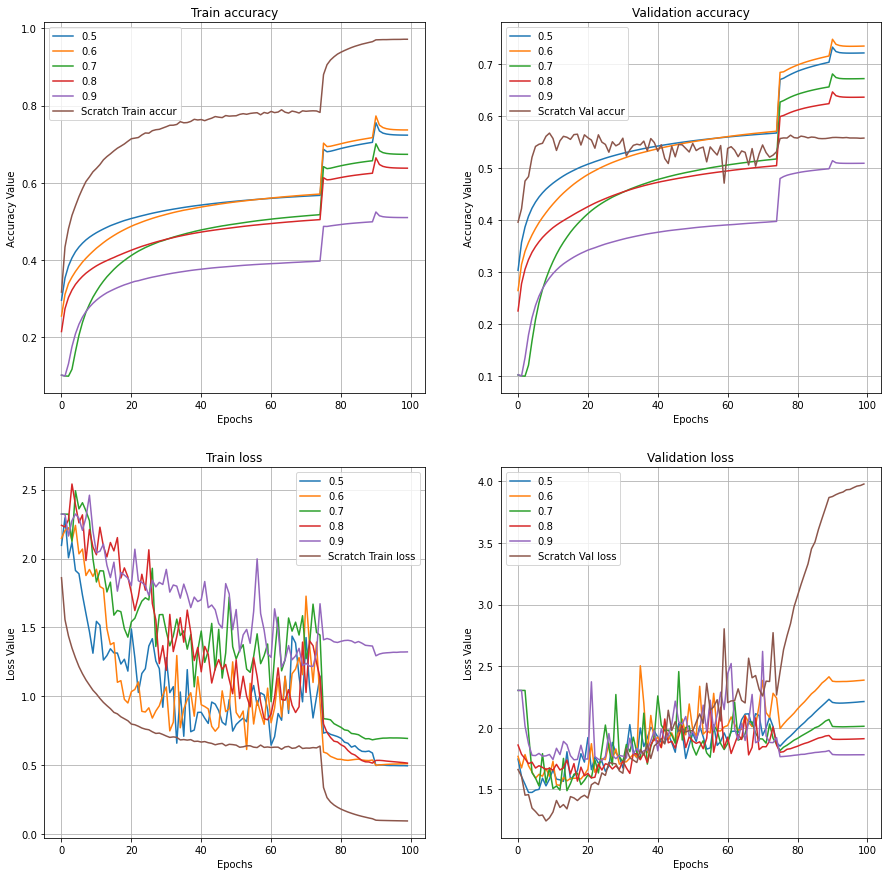

In [28]:
figname= f"test2_seed42.png"
eval_plot(dico, figname, scratch = True)

In [29]:
dico

{'scratch_hist': (array([0.31704   , 0.43366   , 0.48108   , 0.51565999, 0.54053998,
         0.56427997, 0.58484   , 0.60342002, 0.61540002, 0.62856001,
         0.63744003, 0.6473    , 0.65957999, 0.66799998, 0.67505997,
         0.68278003, 0.68974   , 0.69507998, 0.70076001, 0.70770001,
         0.71421999, 0.71579999, 0.71741998, 0.72406   , 0.72916001,
         0.72861999, 0.73501998, 0.73755997, 0.73861998, 0.74207997,
         0.74544001, 0.74914002, 0.74931997, 0.75124002, 0.75841999,
         0.75550002, 0.7561    , 0.75910002, 0.76455998, 0.76282001,
         0.76393998, 0.76103997, 0.76455998, 0.76748002, 0.77170002,
         0.77006   , 0.76899999, 0.77425998, 0.77274001, 0.77340001,
         0.77373999, 0.77733999, 0.77912003, 0.77758002, 0.77977997,
         0.78094   , 0.78162003, 0.77627999, 0.78232002, 0.77994001,
         0.78501999, 0.78188002, 0.7834    , 0.78921998, 0.78303999,
         0.78064001, 0.78588003, 0.78390002, 0.78087997, 0.78652   ,
         0.7853999

In [30]:
#Save data
np.save("summary.npy", dico)